# Clustering Yelp Restaurants Part 2

In this part, I have continued to work with the [Yelp dataset](https://www.yelp.com/dataset/challenge) that we used in part 1. Download the data from Round 10. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

We will continue to try to find culinary districts in Las Vegas. 

(As a reminder from last time, these are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness.)

However, in this analysis we will not use the Yelp-supplied "categories" to cluster for similarity as we did in Part 1.

Instead we will cluster the reviews themselves, extracting categories in an unsupervised fashion.  

In [1]:
import json
import pandas as pd
import sklearn
import nltk
from __future__ import print_function 
from sklearn.decomposition import TruncatedSVD 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import Normalizer 
from sklearn import metrics 
from sklearn.cluster import KMeans, MiniBatchKMeans
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.utils.extmath import randomized_svd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster,dendrogram, linkage, cophenet
from sklearn import mixture
import operator

%matplotlib inline
%config InlineBackend.figure_format='retina'
# nltk.download('stopwords')

In [2]:
df_reviews = pd.read_csv('review.csv')
df_reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0.0,uYHaNptLzDLoV_JZ_MuzUA,5.0,My girlfriend and I stayed here for 3 nights a...,0.0,cjpdDjZyprfyDG3RlkVG3w
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0.0,uYHaNptLzDLoV_JZ_MuzUA,3.0,If you need an inexpensive place to stay for a...,0.0,bjTcT8Ty4cJZhEOEo01FGA
2,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0.0,uYHaNptLzDLoV_JZ_MuzUA,4.0,Location is everything and this hotel has it! ...,0.0,oU2SSOmsp_A8JYI7Z2JJ5w
3,uYHaNptLzDLoV_JZ_MuzUA,0,2015-02-21,0.0,uYHaNptLzDLoV_JZ_MuzUA,4.0,"Beautiful space, great location, staff rock. T...",0.0,yx8vNXUL0D0HS8rUIC7AFA
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-07-07,0.0,uYHaNptLzDLoV_JZ_MuzUA,4.0,This is a fairly new property I think. It is a...,0.0,zXnH6W74FAJQ7q7b-NuBsA


In [3]:
data = []
columns = ['business_id', 'Latitude', 'Longitude']
for obj in open('business.json'):
    attr = []
    ob = json.loads(obj)
    blah = dict(ob.items())
    if (blah['city'] == 'Las Vegas')&('Restaurants' in blah['categories']):
        attr.append(blah['business_id'])
        attr.append(blah['latitude'])
        attr.append(blah['longitude'])
        data.append(attr)
df_business = pd.DataFrame(data, columns=columns)        
df_business.head()

,business_id,Latitude,Longitude
0,LDMCrFlGIFUN6L-FEFgzWg,36.196203,-115.116799
1,QTH_XGh4rWYdd0fTW-tUDw,36.112519,-115.242605
2,DiA78qPtp6rfRNdomzjBbw,36.083384,-115.033995
3,YTqtM2WFhcMZGeAGA08Cfg,36.159363,-115.135949
4,Oto60yDwk1z72WmfWEYrjg,36.012191,-115.173993


In [4]:
df_merged = df_business.merge(df_reviews, on='business_id')
df_merged = df_merged[['business_id', 'Latitude', 'Longitude', 'text']]
df_merged.head()

,business_id,Latitude,Longitude,text
0,LDMCrFlGIFUN6L-FEFgzWg,36.196203,-115.116799,I've been eating chicken at el poll loco since...
1,LDMCrFlGIFUN6L-FEFgzWg,36.196203,-115.116799,I'm at training for work and went for a quick ...
2,LDMCrFlGIFUN6L-FEFgzWg,36.196203,-115.116799,Newly decorated. Great chicken. Ordering could...
3,LDMCrFlGIFUN6L-FEFgzWg,36.196203,-115.116799,Given this location is close to my work I find...
4,LDMCrFlGIFUN6L-FEFgzWg,36.196203,-115.116799,Food is good prices are good and service was g...


In [5]:
df_unique_business = df_merged[['business_id', 'Latitude', 'Longitude']]
df_unique_business = df_unique_business.drop_duplicates()
df_unique_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5682 entries, 0 to 826630
Data columns (total 3 columns):
business_id    5682 non-null object
Latitude       5682 non-null float64
Longitude      5682 non-null float64
dtypes: float64(2), object(1)
memory usage: 177.6+ KB


In [6]:
reviews_list = []
for i in df_unique_business['business_id']:
    reviews = ', '.join(df_merged[df_merged['business_id'] == i]['text'].tolist())
    reviews_list.append(reviews)

In [7]:
df_unique_business['review'] = reviews_list
df_unique_business = df_unique_business.reset_index(drop=True)
df_to_use = df_unique_business[['Latitude', 'Longitude', 'review']]
df_to_use['Latitude'] = (df_to_use['Latitude'] - df_to_use['Latitude'].mean()) / df_to_use['Latitude'].std()
df_to_use['Longitude'] = (df_to_use['Longitude'] - df_to_use['Longitude'].mean()) / df_to_use['Longitude'].std()
df_to_use.head()

c:\users\yash\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\yash\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Latitude,Longitude,review
0,1.155310,1.121126,I've been eating chicken at el poll loco since...
1,-0.300530,-0.749492,The last two times I've been to this place the...
2,-0.807387,2.352334,Love that this store is in my neighborhood. It...
3,0.514411,0.836380,Great place. There was a man here who was very...
4,-2.045937,0.270701,Below mediocre. Our expectations were not very...


In [8]:
# stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
#          for sent in sent_tokenize(message)
#         for word in word_tokenize(sent))
#         for message in df_to_use['review']]
# stemmed_data

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
dtm = vectorizer.fit_transform(df_to_use['review'])
terms = vectorizer.get_feature_names()

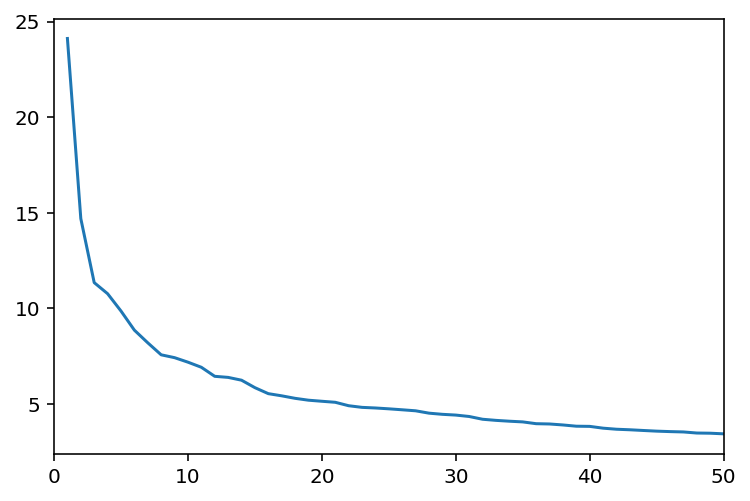

In [10]:
U, Sigma, VT= randomized_svd(dtm,50)
plt.xlim([0,50])
plt.plot(range(1,len(Sigma)+1),Sigma)

In [11]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(8, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm) 
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
vt = lsa.components_


df = pd.DataFrame.from_records(dtm_lsa,columns = ['component1','component2','component3','component4', 'component5', 'component6', 'component7', 'component8'])
df.head()

,component1,component2,component3,component4,component5,component6,component7,component8
0,0.773292,-0.226712,0.405846,0.286338,0.094702,0.270381,-0.146050,-0.022714
1,0.654462,-0.238597,0.581832,0.398608,-0.052863,-0.090283,-0.057950,0.055057
2,0.879671,-0.205107,-0.095440,0.079936,0.200568,0.250416,-0.194582,-0.166776
3,0.799801,-0.292458,0.242422,0.357850,0.117464,-0.265229,0.010250,-0.060930
4,0.721269,-0.270703,0.452853,0.349369,0.021697,-0.280631,-0.000089,-0.011506


In [12]:
component_labels = []
for i in range(8):
    top = np.argsort(vt[i])[::-1]
    topterms = [terms[top[f]] for f in range(20)]
    component_labels.append(', '.join(topterms))
component_labels

['pizza, bar, fries, delicious, cheese, burger, sauce, salad, rice, breakfast, sushi, sandwich, lunch, tacos, server, amazing, meal, location, steak, minutes',
 'pizza, crust, pizzas, delivery, pepperoni, wings, slice, hut, toppings, cheese, knots, garlic, italian, driver, called, papa, slices, dough, pie, oven',
 'tacos, taco, mexican, burrito, asada, carne, salsa, roberto, fries, beans, chips, pastor, burritos, guacamole, burger, nachos, cheese, drive, tortillas, carnitas',
 'sushi, tacos, taco, burrito, mexican, asada, rice, pizza, carne, salsa, rolls, roll, thai, chinese, fish, ayce, beans, roberto, pastor, shrimp',
 'thai, chinese, rice, pad, curry, soup, noodles, pho, fried, beef, pork, noodle, delivery, shrimp, egg, dish, mein, dishes, chow, spicy',
 'burger, sandwich, fries, sushi, subway, drive, location, burgers, fast, sandwiches, subs, customer, mcdonald, rice, thai, employees, delivery, chinese, window, hot',
 'burger, fries, burgers, thai, bar, wings, bartender, beer, pad,

In [13]:
component_labels = ['Bar', 'Pizza', 'Mexican', 'Sushi', 'Thai', 'FastFood', 'Burger', 'Subway']
df.columns = component_labels
df.head()

,Bar,Pizza,Mexican,Sushi,Thai,FastFood,Burger,Subway
0,0.773292,-0.226712,0.405846,0.286338,0.094702,0.270381,-0.146050,-0.022714
1,0.654462,-0.238597,0.581832,0.398608,-0.052863,-0.090283,-0.057950,0.055057
2,0.879671,-0.205107,-0.095440,0.079936,0.200568,0.250416,-0.194582,-0.166776
3,0.799801,-0.292458,0.242422,0.357850,0.117464,-0.265229,0.010250,-0.060930
4,0.721269,-0.270703,0.452853,0.349369,0.021697,-0.280631,-0.000089,-0.011506


In [14]:
label_series = df.idxmax(axis=1)
df['Latitude'] = df_to_use['Latitude']
df['Longitude'] = df_to_use['Longitude']
df.head()

,Bar,Pizza,Mexican,Sushi,Thai,FastFood,Burger,Subway,Latitude,Longitude
0,0.773292,-0.226712,0.405846,0.286338,0.094702,0.270381,-0.146050,-0.022714,1.155310,1.121126
1,0.654462,-0.238597,0.581832,0.398608,-0.052863,-0.090283,-0.057950,0.055057,-0.300530,-0.749492
2,0.879671,-0.205107,-0.095440,0.079936,0.200568,0.250416,-0.194582,-0.166776,-0.807387,2.352334
3,0.799801,-0.292458,0.242422,0.357850,0.117464,-0.265229,0.010250,-0.060930,0.514411,0.836380
4,0.721269,-0.270703,0.452853,0.349369,0.021697,-0.280631,-0.000089,-0.011506,-2.045937,0.270701


In [15]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

In [16]:
def sc_evaluate_clusters(df_final,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
        kmeans.fit_predict(df_final)
        s[k] = metrics.silhouette_score(df_final,kmeans.labels_,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')

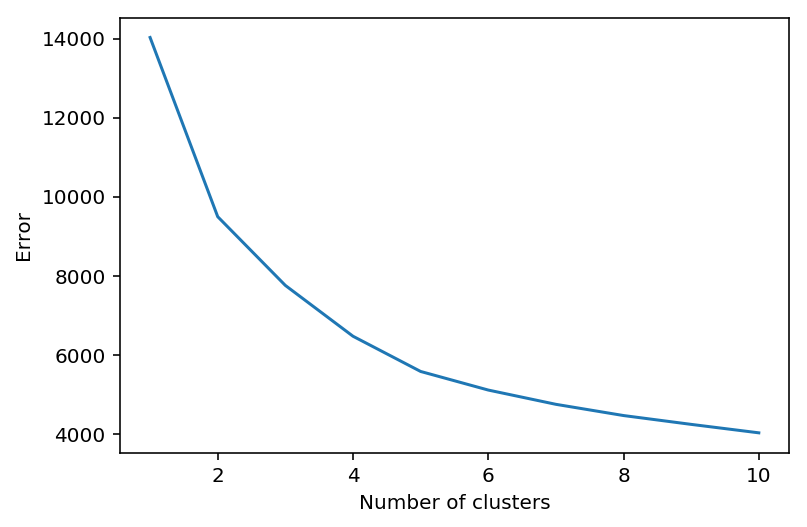

In [17]:
evaluate_clusters(df,10)

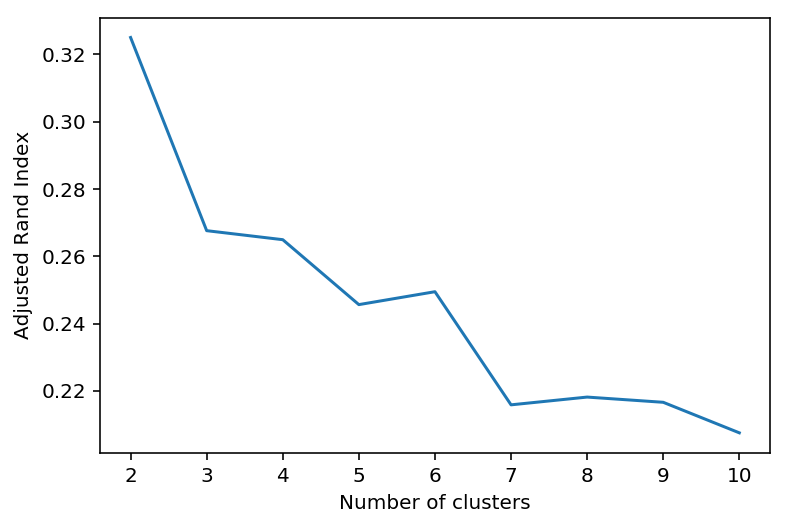

In [18]:
sc_evaluate_clusters(df,10)

In [19]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=100) 
km_clusters = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
km_0 = np.where(km_clusters==0)
km_1 = np.where(km_clusters==1)
km_2 = np.where(km_clusters==2)
km_3 = np.where(km_clusters==3)
km_clusters_list = [km_0, km_1, km_2, km_3]

In [20]:
hc = linkage(df, method ='complete',metric = 'euclidean')
hc_cluster = fcluster(hc,6,criterion='distance')
hc_0 = np.where(hc_cluster==1)
hc_1 = np.where(hc_cluster==2)
hc_2 = np.where(hc_cluster==3)
hc_3 = np.where(hc_cluster==4)
hc_clusters_list = [hc_0, hc_1, hc_2]
hc_2

(array([   0,    2,    3, ..., 5678, 5679, 5680], dtype=int64),)

In [21]:
gmm = mixture.GMM(n_components=5, covariance_type='spherical')
gmm.fit(df)
gaussian = gmm.predict(df)
mean = gmm.means_
covar = gmm.covars_
gmm_0 = np.where(gaussian==0)
gmm_1 = np.where(gaussian==1)
gmm_2 = np.where(gaussian==2)
gmm_3 = np.where(gaussian==3)
gmm_clusters_list = [gmm_0, gmm_1, gmm_2, gmm_3]

c:\users\yash\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\yash\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\yash\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\yash\a

In [22]:
def find_categoryLabel(cluster):
    max_value = 0
    labelDict = {}
    for i in cluster[0]:
        j = label_series[int(i)]
        if j not in icats:
            if j not in labelDict:
                labelDict[j] = 1
               
            else:
                labelDict[j] += 1
    cat =  max(labelDict.items(), key=operator.itemgetter(1))[0]
    icats.append(cat)
    return cat

In [23]:
km_clusters_labels = []
hc_clusters_labels = []
gmm_clusters_labels = []
icats = []
for i in km_clusters_list:
    km_clusters_labels.append(find_categoryLabel(i))
icats = []
for i in gmm_clusters_list:
    gmm_clusters_labels.append(find_categoryLabel(i))
icats = []
for i in hc_clusters_list:
    hc_clusters_labels.append(find_categoryLabel(i))
icats = []
hc_clusters_list.append(hc_3)
hc_clusters_labels.append(find_categoryLabel(hc_3))
km_clusters_labels

['Bar', 'Pizza', 'Mexican', 'Sushi']

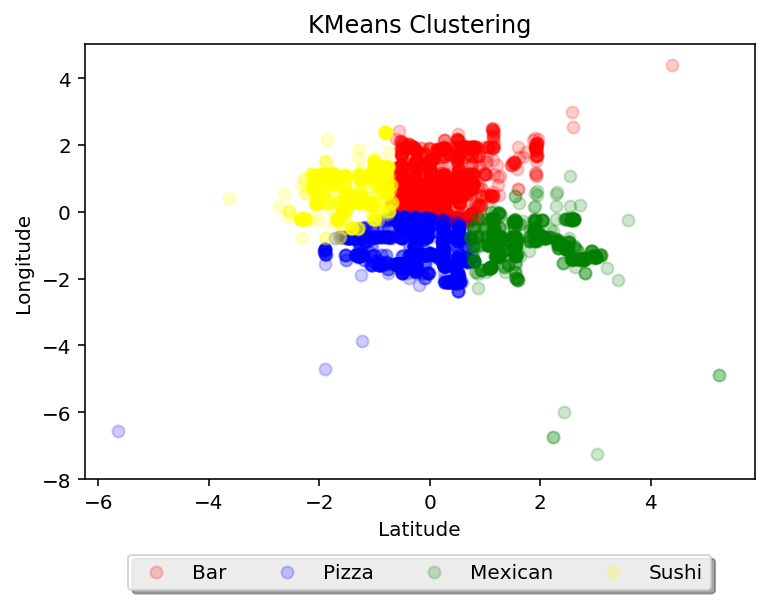

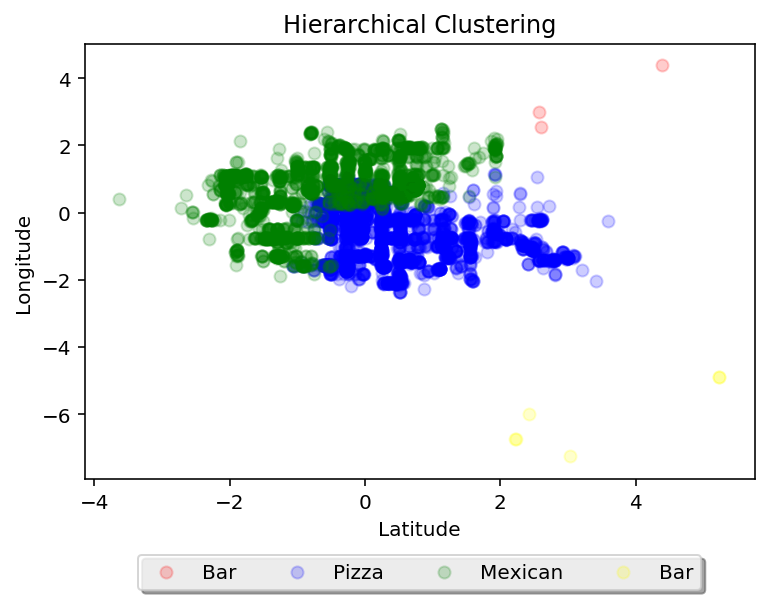

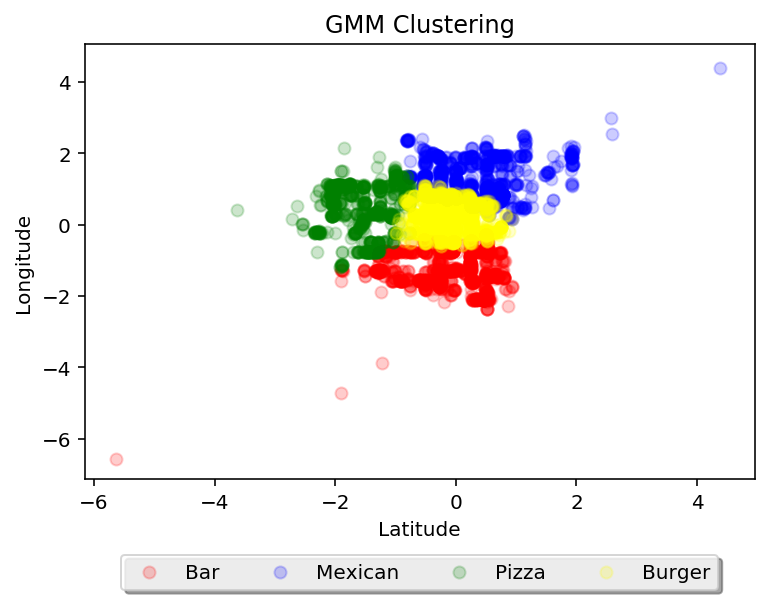

In [24]:
colors = ['red', 'blue', 'green', 'yellow']

plt.figure(0)
p = 0
for i in km_clusters_list:
    for j in i:
        plt.scatter(df['Latitude'][j], df['Longitude'][j], color = colors[p], alpha=0.2)
        p += 1

plt.title('KMeans Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend([km_clusters_labels[i] for i in range(len(km_clusters_labels))],bbox_to_anchor=(0.5, -0.15), loc='upper center', fancybox = True, shadow = True, ncol=5)

plt.figure(1)
p = 0
for i in hc_clusters_list:
    for j in i:
        plt.scatter(df['Latitude'][j], df['Longitude'][j], color = colors[p], alpha=0.2)
        p += 1

plt.title('Hierarchical Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend([hc_clusters_labels[i] for i in range(len(hc_clusters_labels))],bbox_to_anchor=(0.5, -0.15), loc='upper center', fancybox = True, shadow = True, ncol=5)

plt.figure(2)
p = 0
for i in gmm_clusters_list:
    for j in i:
        plt.scatter(df['Latitude'][j], df['Longitude'][j], color = colors[p], alpha=0.2)
        p += 1

plt.title('GMM Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend([gmm_clusters_labels[i] for i in range(len(gmm_clusters_labels))],bbox_to_anchor=(0.5, -0.15), loc='upper center', fancybox = True, shadow = True, ncol=5)

plt.show()

Cluster commparision of both parts:

Part 1 metrics:
No. of clusters = 5
Error = ~10000
Silhoutte Coefficient = 0.16

Part 2 metrics:
No. of clusters = 4
Error = ~6000
Silhoutte Coefficient = 0.26

We can clearly see that in part 2 we get clusters with lower error and higher silhoutte score.
I believe that part 2 gives us better results because in part to we work on users' reviews which gives us a better term dictionary for the categories to be defined for each restauarnt.

----------